In [28]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import numpy as np
import pandas as pd
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

In [29]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

#### Imports for PCA

In [30]:
from sklearn.decomposition import PCA,KernelPCA

## Principal Component Analysis (PCA)

PCA **Unsupervised** dimensionality reduction method. PCA produces a low-dimensional representation of a dataset that contains as much as possible of the variation in the dataset.

Assuming the dataset has n rows (observations) and p columns (features, predictors), we want to reduce the number of features by combining them to a lower dimension (d) of the feature space. Some features may be redundant, others may not have much influence on the response variable.
 
PCA finds d linear combinations of the p features, that have maximal variance. They are mutually uncorrelated.

The d linear combinations form a new representation of the data in a lower dimension.
 
These derived variables produced by PCA are called the Principal Components(PCs) and can be used in supervised learning problems. Principal Component regression uses the PCs as predictors. This raises the question of how to interpret this linear combination of features.
 
PCA is often used as a tool to reduce the dimension of the data so it can be visualized.

PCA can be applied to both linear and non-linear data (Kernel PCA)



### Geometry of PCA

We can think of PCA as a change of basis.

![](pca.png)

$\text{Figure 1. Principal Component Analysis}$
 
### Terminology

#### Linear combination of the p features with constraints


$$Z_1 = \phi_{11}X_1 + \phi_{21}X_2 + ... + \phi_{p1}X_p\text{ subject to }\sum^p_{j=1}\phi^2_{j1} = 1$$
$$Z_2 = \phi_{12}X_1 + \phi_{22}X_2 + ... + \phi_{p2}X_p\text{ subject to }\sum^p_{j=1}\phi^2_{j2} = 1$$
$$\vdots$$
$$Z_d = \phi_{1d}X_1 + \phi_{2d}X_2 + ... + \phi_{pd}X_p\text{ subject to }\sum^p_{j=1}\phi^2_{jd} = 1$$

$\phi_d = (\phi_{1d},\ldots,\phi_{pd})$ is called a Principal Component loading vector.

The loading vector $\phi_1$ defines the direction in feature space along which the data varies the most. $\phi_2$ is perpendicular to $\phi_1$ and points to the direction with the second highest variance.


The coefficients $\phi_{1d},\ldots,\phi_{pd}$ are called the loadings, d <= p.

The values of the projection of the n data points onto the loading vectors are called the scores.

We constrain sum the loadings to 1, otherwise setting them to be arbitrarily large could result in an arbitrarily large variance.

## Intutition
 
![](ToyPCAExample.png)

$\text{Figure 2. Experimental Setup of System}$

 
### Physical Example 

Imagine you are ignorant of the physical system. You don't know that the underlying dynamics can be expressed as a function of a single variable x.

You decide to place cameras at arbitrary angles around system.

The data will be noisy and redundant 

Each camera reports x and y position and there are 12000 samples (trials) Producing a p x n matrix with p = 6 measurement types an n = 12000 trials.

X is one column of measurement types (features, predictors)
    
$$ 
  X = \begin{bmatrix}
    x_A \\y_A   \\ x_B \\y_B   \\x_C \\y_C
\end{bmatrix} 
$$

 The main idea is to change the basis with the goal of computing the best basis to re-express the data in order to reduce redundancy and noise in the data.
 
To find this new basis: Transform the data by PX = Y, where:

- P is a matrix that transforms X into Y.
- P is a rotation and a stretch of X into Y.
- The rows of P will be the set of new basis vectors for expressing the columns of X.
    
#### Redundancy

When multiple sensors (variables) contain the same information, we hope to reduce redundancy and noise by changing the basis.

The high redundancy in Figure 3c could be caused by having two of the cameras nearby (i.e. cameras B and C in Figure 2).

We could combine r1 and r2 to a single variable that is a linear combination of the two. (i.e. we could just use one camera) 
        
![](redundancy.png)

$\text{Figure 3. Degrees of Redundancy}$

### Covaiarnce Matrix (S)

A covariance matrix quantifies redundancy

#### Visualization for three variables

|S |X|Y|Z|
|:----:|:----:|:----:|:----:|
|X|cov(x,x)  |cov(x,y)  | cov(x,z)   | 
|Y|cov(y,x)  |  cov(y,y)  | cov(y,z)   | 
|Z|cov(z,x) |cov(z,y)  |  cov(z,z)    | 

cov(x,x) = var(x)
 
#### Covariance matrix for our physical example 

X is column-vector of measurements (6x1)

S is a square symmetric (6x6) matrix 

Variance of each measurement is along the diagonal. The covariances between separate measurements are the off-diagonal terms. A large term corresponds to Figure 3c. A zero term corresponds to Figure 3a. 

#### Reduce Redundancy by Diagonalizing the Covariance Matrix
    
To reduce redundancy, we would like each variable to co-vary as little as possible with other variables. Covariances between separate measurements should be equal to  zero. Therefore, we want a Diagonal matrix (i.e. a matrix with zeros on the off-diagonal terms.

PCA is based on the easiest way to form a diagonal matrix from the covariance matrix.

Assume:

1). all basis vectors are perpendicular (orthonormal)  
2). direction of largest variance is the "most" important  

Select the direction in m-dimensional (measurement type) space along which variance in X is maximized (P1). Then find another direction which variance is maximized and is perpendicular to P1 (P2). Continue until m-directions are selected.
  

### PCA Assumptions

The assumptions of the PCA algorithm are:

- Linearity: the data is a linear combination of basis vectors
- The $X_i$s are Gaussian distributed
- The directions of highest variability (i.e. the principal components) represent the interesting dynamics while those with lower variance represent noise
- The principal components are orthogonal (i.e. perpendicular)
 

### PCA Algorithm

1. Scale the data by centering (mean = 0) and scaling the stanard deviation to 1.  
2. Create the covariance matrix of the scaled data.  
3. Calculate the eigenvalues and eigenvectors of the covariance matrix
4. Sort the eigenvalues and eigenvectors in decreasing order.
5. Determine percent of variance explained to determine d (the number of principle components to keep)
6. Construct the projection matrix P (of loading vectors) from the d eigenvectors
7. Construct the d-dimensional feature subspace Y by projecting the scaled data onto P


### PCA Algorithm in Python

In [31]:
iris = sns.load_dataset('iris')
X = iris.iloc[:,0:4].values
y = iris.iloc[:,4].values

#### 1. Scale the data by centering (mean = 0) and scaling the stanard deviation to 1.

In [32]:
X_std = StandardScaler().fit_transform(X)

#### 2. Create the covariance matrix of the scaled data.

In [33]:
print('NumPy covariance matrix: \n')
cov_mat = np.cov(X_std.T)
cov_mat

NumPy covariance matrix: 



array([[ 1.00671141, -0.11835884,  0.87760447,  0.82343066],
       [-0.11835884,  1.00671141, -0.43131554, -0.36858315],
       [ 0.87760447, -0.43131554,  1.00671141,  0.96932762],
       [ 0.82343066, -0.36858315,  0.96932762,  1.00671141]])

#### 3. Calculate the eigenvalues and eigenvectors of the covariance matrix

In [34]:
eig_vals, eig_vecs = np.linalg.eig(cov_mat)

print('\nEigenvalues \n%s' %eig_vals)
print('Eigenvectors \n%s' %eig_vecs)


Eigenvalues 
[2.93808505 0.9201649  0.14774182 0.02085386]
Eigenvectors 
[[ 0.52106591 -0.37741762 -0.71956635  0.26128628]
 [-0.26934744 -0.92329566  0.24438178 -0.12350962]
 [ 0.5804131  -0.02449161  0.14212637 -0.80144925]
 [ 0.56485654 -0.06694199  0.63427274  0.52359713]]


#### 3a. Check that the eigenvectors are orthonormal

In [35]:
# Check orthonormal eigen vectors
for i in range(4):
    print("eigenvector: ",i)
    for j in range(4):
        print(j, round(eig_vecs[i].dot(eig_vecs[j]),10))

eigenvector:  0
0 1.0
1 -0.0
2 -0.0
3 -0.0
eigenvector:  1
0 -0.0
1 1.0
2 -0.0
3 -0.0
eigenvector:  2
0 -0.0
1 -0.0
2 1.0
3 0.0
eigenvector:  3
0 -0.0
1 -0.0
2 0.0
3 1.0


#### 4. Sort the eigenvalues and eigenvectors in decreasing order.


In [36]:
# Make a list of (eigenvalue, eigenvector) tuples
eig_pairs = [(np.abs(eig_vals[i]), eig_vecs[:,i]) for i in range(len(eig_vals))]
# Sort the (eigenvalue, eigenvector) tuples from high to low
eig_pairs.sort(reverse=True)
eig_pairs[0]

(2.9380850501999927,
 array([ 0.52106591, -0.26934744,  0.5804131 ,  0.56485654]))

#### 5. Determine percent of variance explained to determine d (the number of principle components to keep)

In [37]:
tot = sum(eig_vals)
var_exp = [(i / tot)*100 for i in sorted(eig_vals, reverse=True)]
cum_var_exp = np.cumsum(var_exp)
print("Variance explained: ",var_exp)
print("Cummlative variance explained: ",cum_var_exp)

Variance explained:  [72.96244541329986, 22.850761786701785, 3.668921889282881, 0.5178709107154905]
Cummlative variance explained:  [ 72.96244541  95.8132072   99.48212909 100.        ]


Set number of Principal Componets =  2


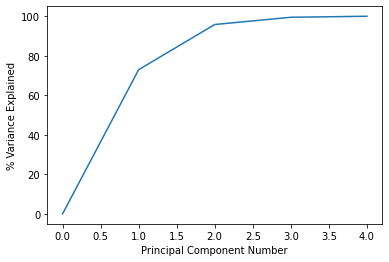

In [38]:
plt.plot((0,1,2,3,4),np.insert(cum_var_exp,0,0))
plt.xlabel("Principal Component Number")
plt.ylabel("% Variance Explained")


d = 2 # Number of Principal Components
print("Set number of Principal Componets = ",d)

#### 6. Construct the projection matrix P from the d eigenvectors

In [39]:
n = len(eig_vals)
P = np.zeros(d*n).reshape(n,d)
for i in range(d):
    for j in range(n):
        P[j,i] = eig_pairs[i][1][j]

print("Projection Matrix")
P

Projection Matrix


array([[ 0.52106591, -0.37741762],
       [-0.26934744, -0.92329566],
       [ 0.5804131 , -0.02449161],
       [ 0.56485654, -0.06694199]])

#### 7. Construct the d-dimensional feature subspace Y by projecting the scaled data X onto P

In [40]:
Y = X_std.dot(P) # XP
d = {'x': Y[:,0],'y': Y[:,1],'Species': iris.loc[:,'species']}
iris2 = pd.DataFrame(data = d)
iris2.head()

,x,y,Species
0,-2.264703,-0.480027,setosa
1,-2.080961,0.674134,setosa
2,-2.364229,0.341908,setosa
3,-2.299384,0.597395,setosa
4,-2.389842,-0.646835,setosa


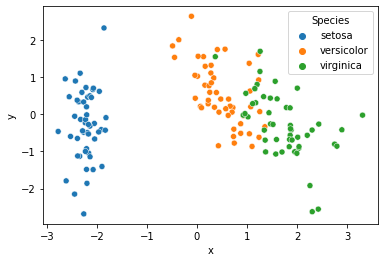

In [41]:
sns.scatterplot('x','y', hue='Species' ,data = iris2);

### PCA function in sklearn

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html

#### Preprocess  Wine data

In [42]:

wine = pd.read_csv('Wine.csv')
X = wine.iloc[:, 0:13].values
y = wine.iloc[:, 13].values
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)
# Scale
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
X_train_std.shape, X_test_std.shape, y_train.shape, y_test.shape

((142, 13), (36, 13), (142,), (36,))

#### Fit and Transform 

In [43]:
pca = PCA(n_components = None)
X_train_pca = pca.fit_transform(X_train_std)
X_test_pca = pca.transform(X_test_std)
X_train_pca.shape, X_test_pca.shape

((142, 13), (36, 13))

#### Variance Explained

In [44]:
var_exp = pca.explained_variance_ratio_
print("Ratio of Variance Explained:")
print(np.round(var_exp,3))
cum_var_exp = np.cumsum(var_exp)
print("Cummulative Variance Explained")
print(np.round(cum_var_exp,3))

Ratio of Variance Explained:
[0.369 0.193 0.108 0.074 0.062 0.049 0.041 0.025 0.023 0.019 0.017 0.013
 0.007]
Cummulative Variance Explained
[0.369 0.562 0.67  0.744 0.806 0.855 0.896 0.921 0.945 0.963 0.981 0.993
 1.   ]


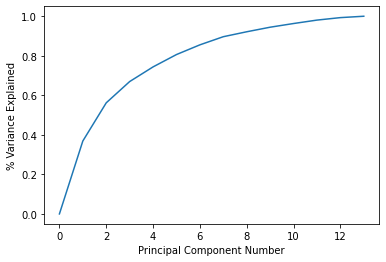

In [45]:
x = np.arange(len(cum_var_exp)+1)
plt.plot(x,np.insert(cum_var_exp,0,0))
plt.xlabel("Principal Component Number")
plt.ylabel("% Variance Explained");


#### Use transformed feature array in a Logistic Regression model

#### Regression with two features

In [46]:
from sklearn.linear_model import LogisticRegression
# Apply PCA
pca = PCA(n_components = 2)
X_train_pca2 = pca.fit_transform(X_train)
X_test_pca2 = pca.transform(X_test)
var_exp = pca.explained_variance_ratio_
print("Variance Explained: ",var_exp)
model = LogisticRegression(random_state = 0) #Regression with two features
model.fit(X_train_pca2, y_train)

Variance Explained:  [0.99786106 0.00194267]


LogisticRegression(random_state=0)

#### PCA results

In [47]:
# Predicting the Test set results
y_pred = model.predict(X_test_pca2)

# Making the Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
accuracy = np.trace(cm)/np.sum(cm)
print("accuracy: ",round(accuracy,2))

accuracy:  0.78


### Kernal PCA

Kernal PCA is PCA for non-linear data.

We use the Kernel Trick like we did with Support Vector Machines. Map the data to higher dimension to separate data with hyperplane. Use Kernel functions which will compute the dot product in the mapped dimension . We don't actually need to do the mapping.

#### Generate some non-linear data

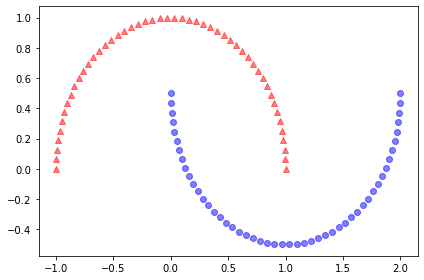

In [48]:
from sklearn.datasets import make_moons

X, y = make_moons(n_samples=100, random_state=123)

plt.scatter(X[y == 0, 0], X[y == 0, 1], color='red', marker='^', alpha=0.5)
plt.scatter(X[y == 1, 0], X[y == 1, 1], color='blue', marker='o', alpha=0.5)

plt.tight_layout()

In [49]:
X.shape,y.shape

((100, 2), (100,))

### Sklearn non-kernel Principal Component Analysis 

#### Fit and transform the data into the top 2 components


In [50]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X)
X_pca.shape

(100, 2)

#### Visualize original and transformed data

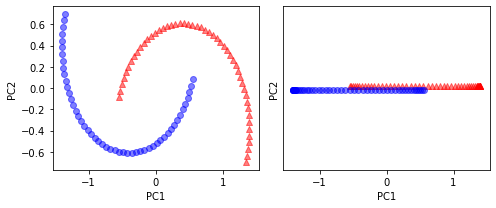

In [51]:
fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(7, 3))

ax1.scatter(X_pca[y == 0, 0], X_pca[y == 0, 1], color='red', marker='^', alpha=0.5)
ax1.scatter(X_pca[y == 1, 0], X_pca[y == 1, 1], color='blue', marker='o', alpha=0.5)

ax2.scatter(X_pca[y == 0, 0], np.zeros((50, 1)) + 0.02, color='red', marker='^', alpha=0.5) # LD1 only
ax2.scatter(X_pca[y == 1, 0], np.zeros((50, 1)) - 0.02, color='blue', marker='o', alpha=0.5)

ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax2.set_ylim([-1, 1])
ax2.set_yticks([])
ax2.set_xlabel('PC1')
ax2.set_ylabel('PC2')
plt.tight_layout()

### Kermel PCS Algorithm

In [52]:
from scipy.spatial.distance import pdist, squareform
from scipy import exp
from scipy.linalg import eigh

#### Compute pairwise squared distances

In [53]:
sq_dists = pdist(X, 'sqeuclidean')
print(sq_dists.shape) 
mat_sq_dists = squareform(sq_dists) # Convert pairwise distances into a square matrix.
mat_sq_dists.shape

(4950,)


(100, 100)

#### Radial Basis Function (RBF) Kernel

<div style="font-size: 115%;"> 
$$K(\vec{x_i},\vec{x_j}) = exp(-\gamma||\vec{x_i} - \vec{_j}||^2_2) \text{ where }\gamma > 0$$
</div>


In [54]:
# Compute the symmetric kernel matrix.
gamma = 15
K = np.exp(-gamma * mat_sq_dists)
K.shape

(100, 100)

#### Center the kernel matrix.

Use this centering trick to center the kernel matrix.
 
#### $K_{centered} = K − 1_n K − K1_n + 1_nK1_n = (I − 1_n)K(I − 1_n)$

In [55]:
N = K.shape[0]
one_n = np.ones((N, N)) / N
print(one_n.shape, one_n[0,0])

K = K - one_n.dot(K) - K.dot(one_n) + one_n.dot(K).dot(one_n)
print(K.shape)

(100, 100) 0.01
(100, 100)


#### Obtain eigenpairs from the centered kernel matrix

In [56]:
# scipy.linalg.eigh returns them in ascending order
eigvals, eigvecs = eigh(K)
eigvals, eigvecs = eigvals[::-1], eigvecs[:, ::-1]

eigvals.shape,eigvecs.shape

((100,), (100, 100))

#### Collect the top k eigenvectors into projection matrix

In [57]:
n_components = 2
X_kpca = np.column_stack((eigvecs[:, i] for i in range(n_components)))
X_kpca.shape

(100, 2)

In [58]:

def plot_kpca(X_kpca):
    fig, (ax1,ax2) = plt.subplots(nrows=1,ncols=2, figsize=(7,3))
    ax1.scatter(X_kpca[y==0, 0], X_kpca[y==0, 1], color='red', marker='^', alpha=0.5)
    ax1.scatter(X_kpca[y==1, 0], X_kpca[y==1, 1], color='blue', marker='o', alpha=0.5)

    ax2.scatter(X_kpca[y==0, 0], np.zeros((50,1))+0.02, color='red', marker='^', alpha=0.5)
    ax2.scatter(X_kpca[y==1, 0], np.zeros((50,1))-0.02, color='blue', marker='o', alpha=0.5)

    ax1.set_xlabel('PC1')
    ax1.set_ylabel('PC2')
    ax2.set_ylim([-1, 1])
    ax2.set_yticks([])
    ax2.set_xlabel('PC1')
    plt.tight_layout()

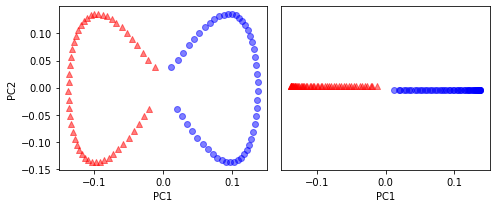

In [59]:
plot_kpca(X_kpca)

### Kernal PCA in sklearn

http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html

In [60]:
kpca = KernelPCA(n_components = 2, kernel = 'rbf', gamma = 15)
X_kpca2 = kpca.fit_transform(X)
X_kpca2.shape

(100, 2)

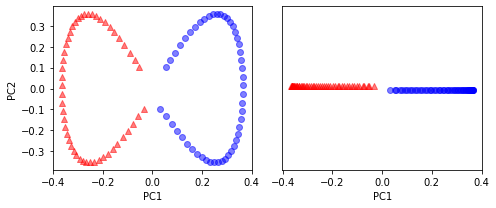

In [61]:
plot_kpca(X_kpca2)

#### Kernel PCA on Iris dataset

In [62]:
iris = sns.load_dataset('iris')
X = iris.iloc[:, 0:4].values
y = iris.iloc[:, 4].values

In [63]:
# Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20, random_state = 0,stratify=y)

# Scale
sc = StandardScaler()
X_train_std = sc.fit_transform(X_train)
X_test_std = sc.transform(X_test)
X_train_std.shape,X_test_std.shape

((120, 4), (30, 4))

In [64]:
# Apply Kernel PCA
kpca = KernelPCA(n_components = None, kernel = 'rbf')
X_train_kpca = kpca.fit_transform(X_train_std)
X_test_kpca = kpca.transform(X_test_std)

var_exp = kpca.lambdas_/np.sum(kpca.lambdas_) # eigenvalues in decreasing order, normalize

X_train_kpca.shape,X_test_kpca.shape,var_exp.shape

((120, 119), (30, 119), (119,))

In [65]:
cum_var_exp = np.cumsum(var_exp)

cum_var_exp[0:15]

array([0.39508669, 0.57684532, 0.66842121, 0.75179169, 0.80719763,
       0.84582942, 0.87183356, 0.89698788, 0.91730744, 0.92990008,
       0.94088662, 0.95154127, 0.95822693, 0.96300384, 0.96747202])

In [66]:
from sklearn.linear_model import LogisticRegression

for d in range(1,6): # number of components
    # Apply kpca
    kpca = KernelPCA(n_components = d, kernel = 'rbf')
    X_train_kpca = kpca.fit_transform(X_train)
    X_test_kpca = kpca.transform(X_test)


    # Fit
    m = LogisticRegression(random_state = 0)
    m.fit(X_train_kpca, y_train)

    # Predict
    y_pred = m.predict(X_test_kpca)

    # Make the Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    accuracy = np.trace(cm)/np.sum(cm)
    print('d = ',d,' Accuracy: ',accuracy)

d =  1  Accuracy:  0.7666666666666667
d =  2  Accuracy:  0.8333333333333334
d =  3  Accuracy:  0.8333333333333334
d =  4  Accuracy:  0.8333333333333334
d =  5  Accuracy:  1.0


#### References

Figure 1 source: "An Introduction to Statistical Learning, with applications in R"  (Springer, 2013) with permission from the authors: G. James, D. Witten,  T. Hastie and R. Tibshirani 

Jon Shlens (2002) A TUTORIAL ON PRINCIPAL COMPONENT ANALYSIS - Derivation, Discussion and
Singular Value Decomposition. 2014 version: https://arxiv.org/pdf/1404.1100.pdf

Principal Component Analysis in Python: https://plot.ly/ipython-notebooks/principal-component-analysis/

Raschka,Sebastin & Mirjalili, Vahid (2017). Python Machine Learning, 2nd Edition, Packt Publishing.

## Appendix

## Solving PCA: Eigenvectors of Covariance Matrix
 
X is the original matrix adjusted so column means = 0
 
Find some orthonormal matrix P where PX = Y, such that the covariance matrix $S_Y = \frac{1}{n-1}YY^T =  \frac{1}{n-1}D$ (i.e. is diagonalized).

P will contain the principal components.
    
$$ S_Y = \frac{1}{n-1}YY^T \\
      = \frac{1}{n-1}(PX)(PX)^T \\
      = \frac{1}{n-1}PXX^TP^T \\
      Let A = XX^T\\
      S_Y = \frac{1}{n-1}PAP^T
$$
      
Linear Algebra Theorems:

- For an orthogonal (i.e. pairwise dot product of columns = 0) matrix A, $A^{-1} = A^T$.Note: A = $XX^T$ is symmetric

- A symmetric matrix can be diagonalized by an orthogonal matrix of its eigenvectors $A = EDE^T$
      
Select P to be the matrix of eigenvectors of $A = XX^T$, P = $E^T$

$$ S_Y = \frac{1}{n-1}P(EDE^T)P^T \\
      = \frac{1}{n-1}P(P^TDP)P^T \\
      = \frac{1}{n-1}(PP^T)D(PP^T) \\
      = \frac{1}{n-1}(PP^{-1})D(PP^{-1}) \\
      = \frac{1}{n-1}D
$$
 